In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
import sys 
# sys.path.append("/Users/julianganzabal/facultad/lab-ml/mllab-tools")
from RNN_utils import encode_io_pairs, chars_to_one_hot, sample
from fnn_helper import PlotLosses

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Elegimos una palabra que tenga una letra repetida

In [171]:
text="HELLO"

In [172]:
chars = sorted(set(text))
print(chars)

['E', 'H', 'L', 'O']


In [173]:
window_size=1
chars_to_indices = dict((c, i) for i, c in enumerate(chars))  # map each unique character to unique integer
indices_to_chars = dict((i, c) for i, c in enumerate(chars))

## Texto a One-hot

In [174]:
chars_to_one_hot(text, chars, chars_to_indices, window_size)*1

array([[[0, 1, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]]])

## One-hot a caracter

In [175]:
print(indices_to_chars[np.argmax([1, 0, 0, 0])])
print(indices_to_chars[np.argmax([0, 1, 0, 0])])

E
H


## Preparo entrada/salida:  
### N=4, T=1, D=4

In [176]:
window_size = 1
step_size = 1
X, y = encode_io_pairs(text, chars, window_size, step_size)

In [177]:
print('X:', X.shape, 'y:', y.shape)

X: (4, 1, 4) y: (4, 4)


In [178]:
print(X*1)

[[[0 1 0 0]]

 [[1 0 0 0]]

 [[0 0 1 0]]

 [[0 0 1 0]]]


In [179]:
print(y*1)

[[1 0 0 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 0 1]]


### Armo modelo RNN

In [180]:
from keras.layers import SimpleRNN, Dense
from keras.models import Sequential

In [181]:
model = Sequential()
model.add(SimpleRNN(10, input_shape=(window_size,len(chars))))
model.add(Dense(len(chars), activation="softmax"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_5 (SimpleRNN)     (None, 10)                150       
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 44        
Total params: 194
Trainable params: 194
Non-trainable params: 0
_________________________________________________________________


### Entreno el modelo

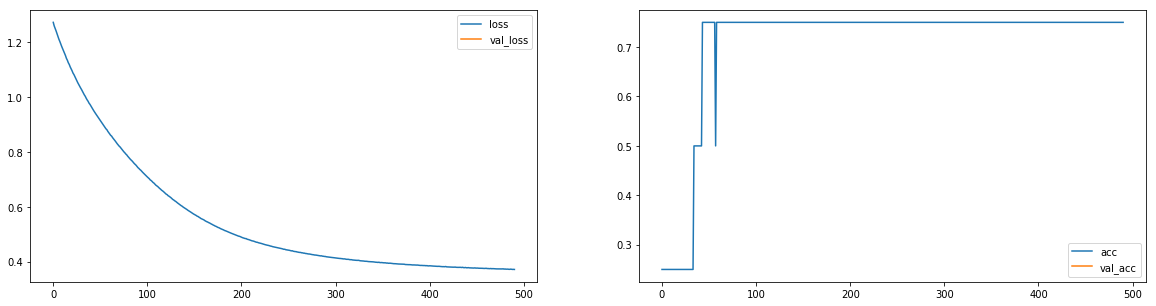

4/4 [==============================] - 0s - loss: 0.3715 - acc: 0.7500     
Epoch 492/500
4/4 [==============================] - 0s - loss: 0.3716 - acc: 0.7500     
Epoch 493/500
4/4 [==============================] - 0s - loss: 0.3712 - acc: 0.7500     
Epoch 494/500
4/4 [==============================] - 0s - loss: 0.3711 - acc: 0.7500     
Epoch 495/500
4/4 [==============================] - 0s - loss: 0.3712 - acc: 0.7500     
Epoch 496/500
4/4 [==============================] - 0s - loss: 0.3710 - acc: 0.7500     
Epoch 497/500
4/4 [==============================] - 0s - loss: 0.3707 - acc: 0.7500     
Epoch 498/500
4/4 [==============================] - 0s - loss: 0.3707 - acc: 0.7500         
Epoch 499/500
4/4 [==============================] - 0s - loss: 0.3710 - acc: 0.7500     
Epoch 500/500
4/4 [==============================] - 0s - loss: 0.3714 - acc: 0.7500         


In [182]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
plot_losses = PlotLosses(plot_interval=10, evaluate_interval=None)
model.fit(X,y, epochs=500, batch_size=1, verbose=1, callbacks=[plot_losses])

### Predicción usando argmax

In [183]:
char_to_predict = text[0]
to_predict = chars_to_one_hot(char_to_predict, chars, chars_to_indices, window_size)*1
print(char_to_predict, '=', to_predict)
predicted = model.predict(to_predict)
print(predicted)
print(indices_to_chars[np.argmax(predicted)])

H = [[[0 1 0 0]]]
[[ 0.97144735  0.00547999  0.01885273  0.00421994]]
E


### Predicción muestrando
#### Ejemplo generico

In [184]:
# probar con temperaturas 0.1, 1, 10
temperature = 1
probabilities = [0.4, 0.1, 0.5]
for i in range(5):
    print(sample(probabilities, temperature, verbose=True))

[ 0.4  0.1  0.5]
0
[ 0.4  0.1  0.5]
0
[ 0.4  0.1  0.5]
2
[ 0.4  0.1  0.5]
0
[ 0.4  0.1  0.5]
0


### Ejemplo con caracteres aprendidos

In [185]:
to_predict = chars_to_one_hot(char_to_predict, chars, chars_to_indices, window_size)*1
predicted = model.predict(to_predict)
print('predicted probs:',predicted)
iterat = 100
temp = 1 # 1, 0.5, 0.1, 0.01
results = []
for i in range(iterat):
    results.append(indices_to_chars[sample(predicted[0], temp)])
print(results)

predicted probs: [[ 0.97144735  0.00547999  0.01885273  0.00421994]]
['E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'L', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']


In [186]:
chars_to_predict = text[:4]
print(chars_to_predict)
to_predict = chars_to_one_hot(chars_to_predict, chars, chars_to_indices, window_size)*1
print(to_predict)

HELL
[[[0 1 0 0]
  [1 0 0 0]
  [0 0 1 0]
  [0 0 1 0]]]


In [187]:
to_predict.reshape(4,1,4)

array([[[0, 1, 0, 0]],

       [[1, 0, 0, 0]],

       [[0, 0, 1, 0]],

       [[0, 0, 1, 0]]])

In [188]:
predicted = model.predict(to_predict.reshape(4,1,4))
print(predicted)
for i, row in enumerate(predicted):
    print(indices_to_chars[np.argmax(to_predict[:,i])], row, indices_to_chars[np.argmax(row)])

[[  9.71447349e-01   5.47999283e-03   1.88527349e-02   4.21994133e-03]
 [  1.64124537e-02   3.67018452e-04   9.61169958e-01   2.20504869e-02]
 [  8.35211016e-03   4.03430080e-03   5.00467300e-01   4.87146318e-01]
 [  8.35211016e-03   4.03430080e-03   5.00467300e-01   4.87146318e-01]]
H [ 0.97144735  0.00547999  0.01885273  0.00421994] E
E [  1.64124537e-02   3.67018452e-04   9.61169958e-01   2.20504869e-02] L
L [ 0.00835211  0.0040343   0.5004673   0.48714632] L
L [ 0.00835211  0.0040343   0.5004673   0.48714632] L


Notar que la L tiene alta probabilidad tanto para la 'L' como la 'O'

## T = 2

In [278]:
window_size = 2
X_2, y_2 = encode_io_pairs(text, chars, window_size, step_size)

In [279]:
print(X_2*1)

[[[0 1 0 0]
  [1 0 0 0]]

 [[1 0 0 0]
  [0 0 1 0]]

 [[0 0 1 0]
  [0 0 1 0]]]


In [280]:
model_2 = Sequential()
model_2.add(SimpleRNN(10, input_shape=(window_size,len(chars))))
model_2.add(Dense(len(chars), activation="softmax"))
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_16 (SimpleRNN)    (None, 10)                150       
_________________________________________________________________
dense_16 (Dense)             (None, 4)                 44        
Total params: 194
Trainable params: 194
Non-trainable params: 0
_________________________________________________________________


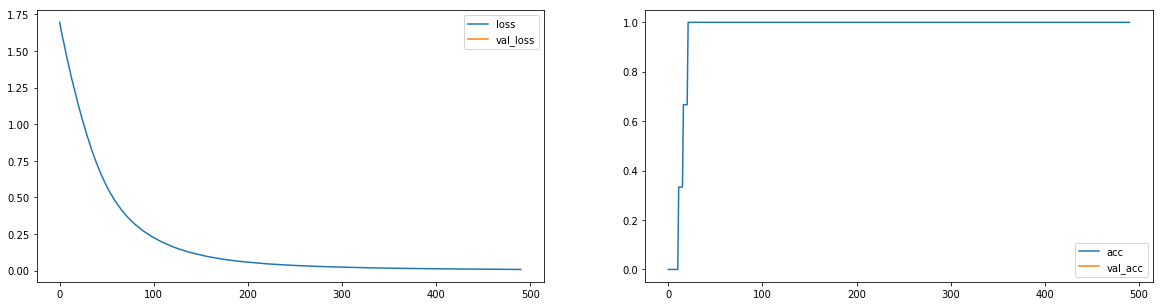

3/3 [==============================] - 0s - loss: 0.0086 - acc: 1.0000     
Epoch 492/500
3/3 [==============================] - 0s - loss: 0.0085 - acc: 1.0000     
Epoch 493/500
3/3 [==============================] - 0s - loss: 0.0085 - acc: 1.0000     
Epoch 494/500
3/3 [==============================] - 0s - loss: 0.0085 - acc: 1.0000     
Epoch 495/500
3/3 [==============================] - 0s - loss: 0.0084 - acc: 1.0000     
Epoch 496/500
3/3 [==============================] - 0s - loss: 0.0084 - acc: 1.0000     
Epoch 497/500
3/3 [==============================] - 0s - loss: 0.0083 - acc: 1.0000     
Epoch 498/500
3/3 [==============================] - 0s - loss: 0.0083 - acc: 1.0000     
Epoch 499/500
3/3 [==============================] - 0s - loss: 0.0083 - acc: 1.0000     
Epoch 500/500
3/3 [==============================] - 0s - loss: 0.0082 - acc: 1.0000     


In [281]:
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
plot_losses = PlotLosses(plot_interval=10, evaluate_interval=None)
model_2.fit(X_2,y_2, epochs=500, batch_size=1, verbose=1, callbacks=[plot_losses])

In [282]:
print(X_2*1)
predicted = model_2.predict(X_2)
for i, row in enumerate(predicted):
    print(indices_to_chars[np.argmax(X_2[i, 0])]+indices_to_chars[np.argmax(X_2[i, 1])], row, indices_to_chars[np.argmax(row)])

[[[0 1 0 0]
  [1 0 0 0]]

 [[1 0 0 0]
  [0 0 1 0]]

 [[0 0 1 0]
  [0 0 1 0]]]
HE [ 0.00154692  0.00145573  0.99477404  0.00222324] L
EL [ 0.00106334  0.00141459  0.99335384  0.00416819] L
LL [ 0.00217365  0.0039621   0.00651939  0.9873448 ] O


- Las probabilidades son practicamente 1
- La cantidad de parametros de la red no cambia respecto a la anterior
- Que pasa si lo implemento con MLP con la cantidad de parámetros?

### Redefino Modelo con pesos aprendidos pero statefull

In [294]:
batch_size=1
model_2_p = Sequential()
model_2_p.add(SimpleRNN(10, batch_input_shape=(batch_size,1,len(chars)), stateful=True))
model_2_p.add(Dense(len(chars), activation="softmax"))
model_2_p.summary()
model_2_p.set_weights(model_2.get_weights())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_20 (SimpleRNN)    (1, 10)                   150       
_________________________________________________________________
dense_18 (Dense)             (1, 4)                    44        
Total params: 194
Trainable params: 194
Non-trainable params: 0
_________________________________________________________________


In [300]:
window_size=1
model_2_p.reset_states()
to_predict = chars_to_one_hot('H', chars, chars_to_indices, window_size)*1
predicted = model_2_p.predict(to_predict)
print(predicted)
indices_to_chars[np.argmax(predicted[0])]

[[ 0.01514301  0.0301888   0.91166031  0.04300787]]


'L'

In [301]:
to_predict = chars_to_one_hot('E', chars, chars_to_indices, window_size)*1
predicted = model_2_p.predict(to_predict)
print(predicted)
indices_to_chars[np.argmax(predicted[0])]

[[ 0.00154692  0.00145573  0.99477404  0.00222324]]


'L'

In [302]:
to_predict = chars_to_one_hot('L', chars, chars_to_indices, window_size)*1
predicted = model_2_p.predict(to_predict)
print(predicted)
indices_to_chars[np.argmax(predicted[0])]

[[ 0.02769768  0.01297444  0.53277564  0.42655221]]


'L'

In [303]:
to_predict = chars_to_one_hot('L', chars, chars_to_indices, window_size)*1
predicted = model_2_p.predict(to_predict)
print(predicted)
indices_to_chars[np.argmax(predicted[0])]

[[ 0.0066806   0.00691507  0.01048999  0.97591442]]


'O'

# Stateful RNN

In [251]:
batch_size=1
model_3 = Sequential()
model_3.add(SimpleRNN(10, batch_input_shape=(batch_size,1,len(chars)), stateful=True))
model_3.add(Dense(len(chars), activation="softmax"))
model_3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_14 (SimpleRNN)    (1, 10)                   150       
_________________________________________________________________
dense_14 (Dense)             (1, 4)                    44        
Total params: 194
Trainable params: 194
Non-trainable params: 0
_________________________________________________________________


In [252]:
X.shape

(4, 1, 4)

In [253]:
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
for i in range(300):
    model_3.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
    model_3.reset_states()

Epoch 1/1
4/4 [==============================] - 0s - loss: 1.3771 - acc: 0.5000     
Epoch 1/1
4/4 [==============================] - 0s - loss: 1.3634 - acc: 0.5000     
Epoch 1/1
4/4 [==============================] - 0s - loss: 1.3511 - acc: 0.5000     
Epoch 1/1
4/4 [==============================] - 0s - loss: 1.3390 - acc: 0.5000     
Epoch 1/1
4/4 [==============================] - 0s - loss: 1.3270 - acc: 0.5000     
Epoch 1/1
4/4 [==============================] - 0s - loss: 1.3152 - acc: 0.5000     
Epoch 1/1
4/4 [==============================] - 0s - loss: 1.3035 - acc: 0.5000     
Epoch 1/1
4/4 [==============================] - 0s - loss: 1.2920 - acc: 0.5000     
Epoch 1/1
4/4 [==============================] - 0s - loss: 1.2808 - acc: 0.5000     
Epoch 1/1
4/4 [==============================] - 0s - loss: 1.2701 - acc: 0.5000     
Epoch 1/1
4/4 [==============================] - 0s - loss: 1.2598 - acc: 0.5000     
Epoch 1/1
4/4 [==============================] - 0s - 

# Voy ingresando de a uno

In [254]:
window_size=1
model_3.reset_states()
to_predict = chars_to_one_hot('H', chars, chars_to_indices, window_size)*1
predicted = model_3.predict(to_predict)
print(predicted)
indices_to_chars[np.argmax(predicted[0])]

[[ 0.91478842  0.01629018  0.05142989  0.01749153]]


'E'

In [255]:
to_predict = chars_to_one_hot('E', chars, chars_to_indices, window_size)*1
predicted = model_3.predict(to_predict)
print(predicted)
indices_to_chars[np.argmax(predicted[0])]

[[ 0.07645242  0.00920512  0.90974671  0.00459569]]


'L'

In [256]:
to_predict = chars_to_one_hot('L', chars, chars_to_indices, window_size)*1
predicted = model_3.predict(to_predict)
print(predicted)
indices_to_chars[np.argmax(predicted[0])]

[[ 0.00488319  0.00749319  0.96308577  0.02453789]]


'L'

In [257]:
to_predict = chars_to_one_hot('L', chars, chars_to_indices, window_size)*1
predicted = model_3.predict(to_predict)
print(predicted)
indices_to_chars[np.argmax(predicted[0])]

[[ 0.00277909  0.00484862  0.10691462  0.88545763]]


'O'

Algunas pruebas mas

In [261]:
# Intento predecir q vendra despues de la L pero sin una secuencia antes
model_3.reset_states()
to_predict = chars_to_one_hot('L', chars, chars_to_indices, window_size)*1
predicted = model_3.predict(to_predict)
print(predicted)
indices_to_chars[np.argmax(predicted[0])]

[[ 0.14208502  0.07548213  0.19545348  0.58697939]]


'O'

In [262]:
# Comparo probs con una L contra LL
model_3.reset_states()
to_predict = chars_to_one_hot('L', chars, chars_to_indices, window_size)*1
predicted = model_3.predict(to_predict)
print(predicted)
print(indices_to_chars[np.argmax(predicted[0])])

to_predict = chars_to_one_hot('L', chars, chars_to_indices, window_size)*1
predicted = model_3.predict(to_predict)
print(predicted)
print(indices_to_chars[np.argmax(predicted[0])])

[[ 0.14208502  0.07548213  0.19545348  0.58697939]]
O
[[ 0.08842172  0.03694637  0.01522267  0.85940921]]
O


In [269]:
# Interesante! HEL -> L, pero EL -> O (No es markov)
model_3.reset_states()
to_predict = chars_to_one_hot('E', chars, chars_to_indices, window_size)*1
predicted = model_3.predict(to_predict)
print(predicted, indices_to_chars[np.argmax(predicted[0])])
to_predict = chars_to_one_hot('L', chars, chars_to_indices, window_size)*1
predicted = model_3.predict(to_predict)
print(predicted, indices_to_chars[np.argmax(predicted[0])])

[[ 0.03048948  0.01891547  0.90614808  0.04444695]] L
[[ 0.01674333  0.03141385  0.61448443  0.33735839]] L


In [272]:
model_3.reset_states()
to_predict = chars_to_one_hot('H', chars, chars_to_indices, window_size)*1
predicted = model_3.predict(to_predict)
print(predicted, indices_to_chars[np.argmax(predicted[0])])
to_predict = chars_to_one_hot('E', chars, chars_to_indices, window_size)*1
predicted = model_3.predict(to_predict)
print(predicted, indices_to_chars[np.argmax(predicted[0])])
to_predict = chars_to_one_hot('L', chars, chars_to_indices, window_size)*1
predicted = model_3.predict(to_predict)
print(predicted, indices_to_chars[np.argmax(predicted[0])])

[[ 0.91478842  0.01629018  0.05142989  0.01749153]] E
[[ 0.07645242  0.00920512  0.90974671  0.00459569]] L
[[ 0.00488319  0.00749319  0.96308577  0.02453789]] L


# Cambio batch size

In [320]:
X_4 = X
y_4 = y
print(X_4.shape)
batch_size=len(X)
model_4 = Sequential()
model_4.add(SimpleRNN(10, batch_input_shape=(batch_size,1,len(chars)), stateful=True))
model_4.add(Dense(len(chars), activation="softmax"))
model_4.summary()

(4, 1, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_24 (SimpleRNN)    (4, 10)                   150       
_________________________________________________________________
dense_22 (Dense)             (4, 4)                    44        
Total params: 194
Trainable params: 194
Non-trainable params: 0
_________________________________________________________________


In [321]:
model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
for i in range(1000):
    model_4.fit(X_4, y_4, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
    model_4.reset_states()

Epoch 1/1
4/4 [==============================] - 0s - loss: 1.7317 - acc: 0.0000e+00
Epoch 1/1
4/4 [==============================] - 0s - loss: 1.7240 - acc: 0.0000e+00
Epoch 1/1
4/4 [==============================] - 0s - loss: 1.7164 - acc: 0.0000e+00
Epoch 1/1
4/4 [==============================] - 0s - loss: 1.7095 - acc: 0.0000e+00
Epoch 1/1
4/4 [==============================] - 0s - loss: 1.7024 - acc: 0.0000e+00
Epoch 1/1
4/4 [==============================] - 0s - loss: 1.6953 - acc: 0.0000e+00
Epoch 1/1
4/4 [==============================] - 0s - loss: 1.6880 - acc: 0.0000e+00
Epoch 1/1
4/4 [==============================] - 0s - loss: 1.6806 - acc: 0.0000e+00
Epoch 1/1
4/4 [==============================] - 0s - loss: 1.6732 - acc: 0.0000e+00
Epoch 1/1
4/4 [==============================] - 0s - loss: 1.6659 - acc: 0.0000e+00
Epoch 1/1
4/4 [==============================] - 0s - loss: 1.6586 - acc: 0.0000e+00
Epoch 1/1
4/4 [==============================] - 0s - loss: 1.651

In [317]:
model_4.reset_states()
to_predict = chars_to_one_hot('H', chars, chars_to_indices, window_size)*1
predicted = model_4.predict(to_predict)
print(predicted)
print(indices_to_chars[np.argmax(predicted[0])])
to_predict = chars_to_one_hot('E', chars, chars_to_indices, window_size)*1
predicted = model_4.predict(to_predict)
print(predicted)
print(indices_to_chars[np.argmax(predicted[0])])

ValueError: Cannot feed value of shape (1, 1, 4) for Tensor 'simple_rnn_21_input:0', which has shape '(4, 1, 4)'

# TimeDistributed wrapper
https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/

# Pad sequences
"The model will learn the zero values carry no information so indeed the sequences are not the same length in terms of content, but same length vectors is required to perform the computation in Keras."
https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

https://machinelearningmastery.com/understanding-stateful-lstm-recurrent-neural-networks-python-keras/

# Encoder decoder
https://machinelearningmastery.com/encoder-decoder-long-short-term-memory-networks/

# Sentiment analysis con CNN y LSTM
https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

# Word-level language model

https://machinelearningmastery.com/how-to-develop-a-word-level-neural-language-model-in-keras/

# return_sequence vs return_state
https://www.quora.com/What-is-the-difference-between-states-and-outputs-in-LSTM

https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/

# Truncated BPTT 
https://machinelearningmastery.com/truncated-backpropagation-through-time-in-keras/